In [10]:
from kf_lab.sims.scenarios import straight_cv
from kf_lab.models.measurement.pos2d import Pos2D
from kf_lab.sensors.sampler import simulate_measurements

truth, t_truth = straight_cv(duration_s=40.0, truth_dt=0.01, v0=12.0, heading_deg=20.0)
meas_model = Pos2D(sigma_px=5.0, sigma_py=5.0)
t_meas, Z  = simulate_measurements(truth, t_truth, meas_model, sensor_hz=5.0)


In [11]:
import numpy as np
from kf_lab.models.motion.cv import CV2D
from kf_lab.filters.kf import KalmanFilter
from kf_lab.core.state import nearest_on_times

x0 = truth[0].copy()
P0 = np.diag([100,100,100,100])
kf = KalmanFilter(x0=x0, P0=P0, motion_model=CV2D(q=0.2), meas_model=meas_model, q=0.2)

est = []
last_t = float(t_meas[0])
for ti, zi in zip(t_meas, Z):
    dt = float(ti - last_t)
    kf.predict(dt)
    kf.update(zi)
    est.append(kf.x.copy())
    last_t = float(ti)
est = np.asarray(est)
truth_s = nearest_on_times(t_truth, truth, t_meas)


In [12]:
import numpy as np

est = np.asarray(est, dtype=float)
truth_s = np.asarray(truth_s, dtype=float)

from kf_lab.metrics.error import rmse_pos_vel
summary = rmse_pos_vel(truth_s, est)  # should silence the error


In [13]:
from kf_lab.metrics.error import rmse_pos_vel
from kf_lab.metrics.consistency import nees, nis

err = est - truth_s
summary = rmse_pos_vel(truth_s, est)
summary["mean_nees"] = float(np.mean(nees(err, kf.P_seq)))
summary["mean_nis"]  = float(np.mean(nis(np.asarray(kf.innovations), kf.S_seq)))
summary

{'rmse_px': 1.4305971660127779,
 'rmse_py': 1.4145536431612036,
 'rmse_pos': 2.011857415619811,
 'rmse_vx': 0.7174556070810524,
 'rmse_vy': 0.625525757956983,
 'rmse_vel': 0.9518534666636981,
 'mean_nees': 1.8590629867599122,
 'mean_nis': 1.9642623332165683}

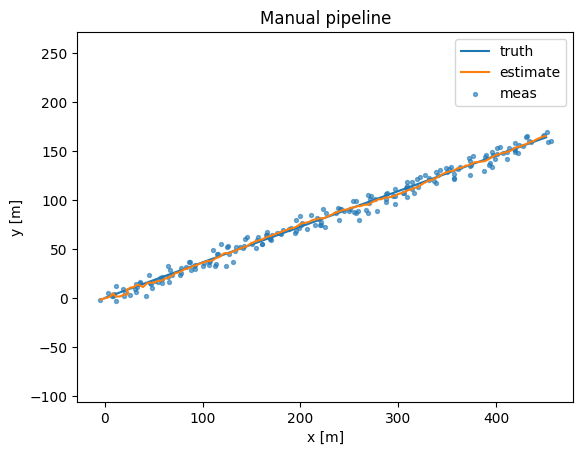

In [14]:
from kf_lab.viz.plots import plot_xy
plot_xy(truth_s, est, Z, title="Manual pipeline")